In [79]:
import mysql.connector
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import price_parser #to handle currencies
import forex_python.converter as converter #to handle currency exchanges
import cpi #to handle inflation
#cpi.update()

# Preprocessing

## Fetch data scraped from IMDB

In [2]:
db = mysql.connector.connect(
  host ="mysql.micro-ondes.ch",
  user ="r4d4r",
  passwd ="1MotDePasse",
  database = "ada_raw_imdb"
)
cursor = db.cursor()
cursor.execute("SELECT * FROM RAW_DATA")
DB_DATA = cursor.fetchall()

In [3]:
DATA_COLUMNS = ["imdb_id", "title", "cast", "imdb_genres", "imdb_runtimes", "imdb_countries", "imdb_languages", "imdb_box_office", "imdb_rating", "imdb_votes", "imdb_plot", "imdb_synopsis"]
DB_DATA = pd.DataFrame(map(lambda x: x[1:], DB_DATA), index=map(lambda x: x[0], DB_DATA), columns=DATA_COLUMNS)
DB_DATA = DB_DATA.replace('NULL',np.NaN)
DB_DATA.drop(columns=["title", "imdb_id", "cast"], inplace = True)
DB_DATA.head()

,imdb_genres,imdb_runtimes,imdb_countries,imdb_languages,imdb_box_office,imdb_rating,imdb_votes,imdb_plot,imdb_synopsis
975900,"['Action', 'Horror', 'Sci-Fi']",['98'],['United States'],['English'],"{'Budget': '$28,000,000 (estimated)', 'Opening...",4.9,55370,"['In 2176, a Martian police unit is sent to pi...","[""200 years in the future, Mars has been colon..."
28463795,"['Crime', 'Drama']",['83'],['Norway'],['Norwegian'],NaN,5.7,40,"['The lonely, divorced and disillusioned lawye...",NaN
261236,['Drama'],['106'],['West Germany'],['German'],NaN,6.0,591,"['Eva, an upper-class housewife, frustratingly...",NaN
10408933,"['Drama', 'Music', 'Musical', 'Romance']",['106'],['United States'],['English'],"{'Budget': '$2,000,000 (estimated)'}",6.9,2164,['This send-up of ragtime song and dance begin...,NaN
175026,"['Drama', 'Romance']",['86'],['United States'],['English'],NaN,5.4,274,"[""After years of abusing his wife, a ne'er-do-...",NaN


## Fetch data from original dataset

### Movies

In [4]:
COLUMNS_NAMES_MOVIES = [
    "freebase_id",
    "movie_name",
    "movie_release_date",
    "freebase_box_office_revenue",
    "freebase_runtime",
    "freebase_languages",
    "freebase_countries",
    "freebase_genres"
]
MOVIE_DATA = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=COLUMNS_NAMES_MOVIES, index_col=0)
MOVIE_DATA.drop(columns=["freebase_id"], inplace = True)
MOVIE_DATA = MOVIE_DATA.replace('NULL',np.NaN)
MOVIE_DATA["movie_release_date"] = pd.to_datetime(MOVIE_DATA["movie_release_date"], errors="coerce")
MOVIE_DATA["movie_release_year"] = MOVIE_DATA["movie_release_date"].dt.year.astype(int, errors="ignore")
MOVIE_DATA.dropna(subset=["movie_release_year"], inplace=True)
MOVIE_DATA.head()

,movie_name,movie_release_date,freebase_box_office_revenue,freebase_runtime,freebase_languages,freebase_countries,freebase_genres,movie_release_year
975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0
28463795,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0
9363483,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0
261236,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0


### Characters

In [5]:
COLUMNS_NAMES_CHARACTERS = [
    "wiki_movie_id",
    "freebase_movie_id",
    "movie_release_date",
    "character_name",
    "actor_date_of_birth",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age_at_movie_release",
    "freebase_character_actor_map_id",
    "freebase_character_id",
    "freebase_actor_id"
]
CHARACTER_DATA = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=COLUMNS_NAMES_CHARACTERS)
CHARACTER_DATA.drop(columns=["freebase_movie_id", "movie_release_date"], inplace = True)
CHARACTER_DATA.dropna(subset=["wiki_movie_id", "character_name"], inplace=True)
CHARACTER_DATA["actor_date_of_birth"] = pd.to_datetime(CHARACTER_DATA["actor_date_of_birth"], errors="coerce")
CHARACTER_DATA.head()

,wiki_movie_id,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Plots

In [6]:
COLUMNS_NAMES_PLOTS = ["wiki_plot"]
PLOT_DATA = pd.read_csv('data/plot_summaries.txt', sep='\t', header=None, names=COLUMNS_NAMES_PLOTS, index_col=0)
PLOT_DATA.head()

,wiki_plot
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


### Tropes

In [7]:
COLUMNS_NAMES_TROPES = [
    "character_type",
    "object"
]
TROPES_DATA = pd.read_csv("data/tvtropes.clusters.txt", sep='\t', header=None, names=COLUMNS_NAMES_TROPES)
TROPES_DATA["character_name"] = TROPES_DATA.apply(lambda x: eval(x["object"])["char"], axis=1)
TROPES_DATA["movie_name"] = TROPES_DATA.apply(lambda x: eval(x["object"])["movie"], axis=1)
TROPES_DATA["freebase_id"] = TROPES_DATA.apply(lambda x: eval(x["object"])["id"], axis=1)
TROPES_DATA["actor_name"] = TROPES_DATA.apply(lambda x: eval(x["object"])["actor"], axis=1)
TROPES_DATA.drop(columns=["object"], axis=1, inplace=True)
TROPES_DATA.head()

,character_type,character_name,movie_name,freebase_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


## Merge imdb and freebase

In [8]:
MOVIE_DATA = MOVIE_DATA.join(DB_DATA)

### About box office

#### Parse imdb data

In [9]:
def func(row):
    if pd.isna(row):
        return np.NaN, np.NaN, np.NaN
    imdb_box_office = eval(row)
    budget = imdb_box_office["Budget"] if "Budget" in imdb_box_office.keys() else np.NaN
    cum_world_box_office = imdb_box_office["Cumulative Worldwide Gross"] if "Cumulative Worldwide Gross" in imdb_box_office.keys() else np.NaN
    weekend_US_box_office = imdb_box_office["Opening Weekend United States"] if "Opening Weekend United States" in imdb_box_office.keys() else np.NaN
    return budget, cum_world_box_office, weekend_US_box_office
        
        
MOVIE_DATA["budget"], MOVIE_DATA["cum_world_box_office"], MOVIE_DATA["weekend_US_box_office"] = zip(*MOVIE_DATA["imdb_box_office"].apply(func))            

#### Handle different currencies

In [10]:
def func(val, year):
    if pd.isna(val):
        return np.NaN
    price = price_parser.Price.fromstring(val)
    if price.currency == "$":
        return price.amount_float
    try:
        c = converter.CurrencyRates()
        date = datetime.datetime(int(year), 1, 1, 0, 0)
        return c.get_rate(price.currency, "USD", date) * price.amount_float
    except:
        return np.NaN
    
MOVIE_DATA["budget"] = MOVIE_DATA.apply(lambda x: func(x["budget"], x["movie_release_year"]), axis=1)
MOVIE_DATA["cum_world_box_office"] = MOVIE_DATA.apply(lambda x: func(x["cum_world_box_office"], x["movie_release_year"]), axis=1)
MOVIE_DATA["weekend_US_box_office"] = MOVIE_DATA.apply(lambda x: func(x["weekend_US_box_office"], x["movie_release_year"]), axis=1)

#### Compare IMDB to Freebase

In [11]:
print((np.log(MOVIE_DATA["cum_world_box_office"].dropna())-np.log(MOVIE_DATA["freebase_box_office_revenue"].dropna())).dropna().mean())
print((np.log(MOVIE_DATA["weekend_US_box_office"].dropna())-np.log(MOVIE_DATA["freebase_box_office_revenue"].dropna())).dropna().mean())

-0.13212905952193935
-2.6568221807037284


C:\Users\edoua\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
MOVIE_DATA["box_office"] = MOVIE_DATA["freebase_box_office_revenue"]
#MOVIE_DATA["box_office"][MOVIE_DATA["box_office"].isna()] = MOVIE_DATA["cum_world_box_office"]
MOVIE_DATA.drop(columns=["freebase_box_office_revenue", "imdb_box_office", "cum_world_box_office", "weekend_US_box_office"], inplace = True)

#### Handle inflation

In [13]:
def func(val, year):
    try:
        return cpi.inflate(val, int(year))
    except:
        np.NaN
    
MOVIE_DATA["budget_inflated"] = MOVIE_DATA.apply(lambda x: func(x["budget"], x["movie_release_year"]), axis=1)
MOVIE_DATA["box_office_inflated"] = MOVIE_DATA.apply(lambda x: func(x["box_office"], x["movie_release_year"]), axis=1)

### Handle languages

In [14]:
def func(freebase, imdb):
    if isinstance(imdb, str):
        languages = set(eval(imdb))
    else:
        languages = set()
    if freebase:
        freebase = eval(freebase)
        for key, val in freebase.items():
            l = val.replace("Language", "").replace("language", "").strip()
            languages.update([l])
    return languages

MOVIE_DATA["languages"] = MOVIE_DATA.apply(lambda x: func(x["freebase_languages"], x["imdb_languages"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_languages", "imdb_languages"], inplace = True)

### Handle countries

In [15]:
def func(freebase, imdb):
    if isinstance(imdb, str):
        countries = set(eval(imdb))
    else:
        countries = set()
    if freebase:
        freebase = eval(freebase)
        for key, val in freebase.items():
            c = val.replace("of America", "").strip()
            countries.update([c])
    return countries

MOVIE_DATA["countries"] = MOVIE_DATA.apply(lambda x: func(x["freebase_countries"], x["imdb_countries"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_countries", "imdb_countries"], inplace = True)

### Handle genres

In [16]:
def func(freebase, imdb):
    if isinstance(imdb, str):
        genres = set(eval(imdb))
    else:
        genres = set()
    if freebase:
        freebase = eval(freebase)
        for key, val in freebase.items():
            g = val.strip()
            genres.update([g])
    return genres

MOVIE_DATA["genres"] = MOVIE_DATA.apply(lambda x: func(x["freebase_genres"], x["imdb_genres"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_genres", "imdb_genres"], inplace = True)
MOVIE_DATA.drop(MOVIE_DATA[MOVIE_DATA["genres"].map(lambda x: "Short Film" in x)].index, inplace=True)

### Handle runtime

In [17]:
def func(freebase, imdb):
    if not isinstance(imdb, str):
        return freebase if not np.isnan(freebase) else np.NaN
    imdb = eval(imdb)
    if not freebase:
        return float(imdb[0])
    if freebase in imdb:
        return freebase   
    return float(imdb[0])

MOVIE_DATA["runtime"] = MOVIE_DATA.apply(lambda x: func(x["freebase_runtime"], x["imdb_runtimes"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_runtime", "imdb_runtimes"], inplace = True)
MOVIE_DATA[MOVIE_DATA["runtime"] > 360] = np.NaN

### Change column datatypes

In [18]:
def func(val):
    if isinstance(val, str):
        return set(eval(val))
    else:
        return np.NaN

MOVIE_DATA["imdb_plot"] = MOVIE_DATA["imdb_plot"].apply(func)
MOVIE_DATA["imdb_synopsis"] = MOVIE_DATA["imdb_synopsis"].apply(func)

### Add wikipedia plots

In [19]:
MOVIE_DATA = MOVIE_DATA.join(PLOT_DATA, how="left")

### Find main characters

In [20]:
def func(i, imdb_plot, imdb_synopsis, wiki_plot):
    characters = CHARACTER_DATA[CHARACTER_DATA["wiki_movie_id"] == i]
    if characters.shape[0] == 0:
        return []
    bigplot = ""
    if isinstance(imdb_plot, set):
        bigplot = bigplot + " " + " ".join(imdb_plot)
    if isinstance(imdb_synopsis, set):
        bigplot = bigplot + " " + " ".join(imdb_synopsis)
    if isinstance(wiki_plot, str):
        bigplot = bigplot + wiki_plot
    if bigplot == "":
        return []
    bigplot = bigplot.casefold()
    occurences = []
    for c, character in characters.iterrows():
        localcount = 0
        for c_part in character["character_name"].casefold().split():
            localcount += bigplot.count(c_part.strip())
        occurences.append(localcount)
    if max(occurences) == 0:
        return []
    return list(characters.iloc[[idx for idx, val in enumerate(occurences) if val == max(occurences)]]["freebase_character_actor_map_id"])

MOVIE_DATA["main_characters"] = MOVIE_DATA.apply(lambda x: func(x.name, x["imdb_plot"], x["imdb_synopsis"], x["wiki_plot"]), axis=1)

### Add tropes to characters

In [21]:
#CHARACTER_DATA = CHARACTER_DATA.join(TROPES_DATA.set_index(["character_name", "actor_name"]), on=["character_name", "actor_name"])
CHARACTER_DATA.head()

,wiki_movie_id,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [22]:
TROPES_DATA.head()

,character_type,character_name,movie_name,freebase_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


### Rearrange columns

In [23]:
COLUMNS_NAMES_MOVIES = ["movie_name", "movie_release_date", "movie_release_year", "runtime", "imdb_rating", "imdb_votes", "languages", "countries", "genres", "budget", "budget_inflated", "box_office", "box_office_inflated", "imdb_plot", "imdb_synopsis", "wiki_plot", "main_characters"]
MOVIE_DATA = MOVIE_DATA[COLUMNS_NAMES_MOVIES]
MOVIE_DATA.head()

,movie_name,movie_release_date,movie_release_year,runtime,imdb_rating,imdb_votes,languages,countries,genres,budget,budget_inflated,box_office,box_office_inflated,imdb_plot,imdb_synopsis,wiki_plot,main_characters
975900,Ghosts of Mars,2001-08-24,2001.0,98.0,4.9,55370.0,{English},{United States},"{Adventure, Space western, Supernatural, Actio...",28000000.0,4.284111e+07,14010832.0,2.143713e+07,"{Set 200 years in the future, intergalactic co...","{200 years in the future, Mars has been coloni...","Set in the second half of the 22nd century, th...",[/m/0jys3m]
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,2000.0,95.0,NaN,NaN,{English},{United States},"{Crime Drama, Drama, Biographical film, Mystery}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
28463795,Brun bitter,1988-01-01,1988.0,83.0,5.7,40.0,{Norwegian},{Norway},"{Crime, Drama, Crime Fiction}",NaN,NaN,NaN,NaN,"{The lonely, divorced and disillusioned lawyer...",NaN,NaN,[]
9363483,White Of The Eye,1987-01-01,1987.0,110.0,NaN,NaN,{English},{United Kingdom},"{Erotic thriller, Psychological thriller, Thri...",NaN,NaN,NaN,NaN,NaN,NaN,A series of murders of rich young women throug...,[]
261236,A Woman in Flames,1983-01-01,1983.0,106.0,6.0,591.0,{German},"{Germany, West Germany}",{Drama},NaN,NaN,NaN,NaN,"{Eva, an upper-class housewife, frustratingly ...",NaN,"Eva, an upper class housewife, becomes frustra...",[]


## Dump to csv

In [24]:
MOVIE_DATA.to_csv("data/movie_processed.csv")

# About the dataset

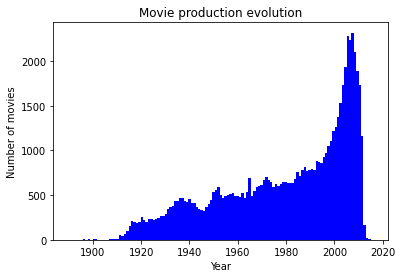

In [25]:
fig, ax = plt.subplots()
ax.hist(MOVIE_DATA["movie_release_year"],bins=int(max(MOVIE_DATA["movie_release_year"])-min(MOVIE_DATA["movie_release_year"])+1), color="blue")
ax.set_xlabel("Year")
ax.set_ylabel("Number of movies")
ax.set_title("Movie production evolution")
plt.show()

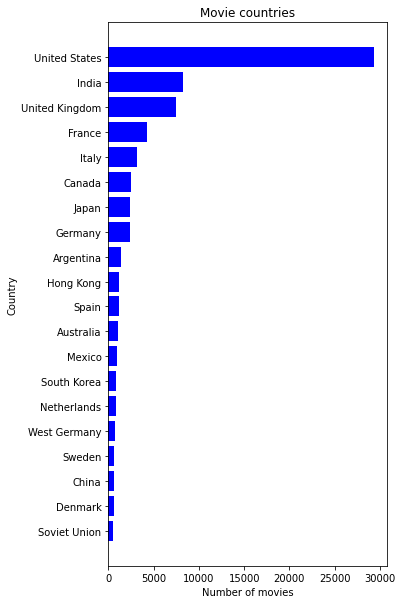

In [26]:
country_data = MOVIE_DATA["countries"].explode().value_counts()[:20].sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(5,10))
ax.barh(country_data.index, country_data.values, color="blue")
ax.set_ylabel("Country")
ax.set_xlabel("Number of movies")
ax.set_title("Movie countries")
plt.show()

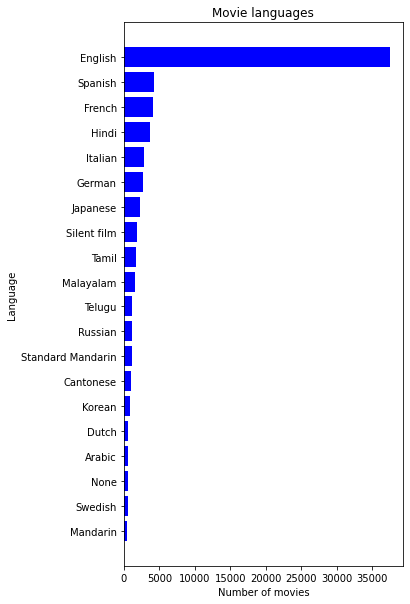

In [27]:
language_data = MOVIE_DATA["languages"].explode().value_counts()[:20].sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(5,10))
ax.barh(language_data.index, language_data.values, color="blue")
ax.set_ylabel("Language")
ax.set_xlabel("Number of movies")
ax.set_title("Movie languages")
plt.show()

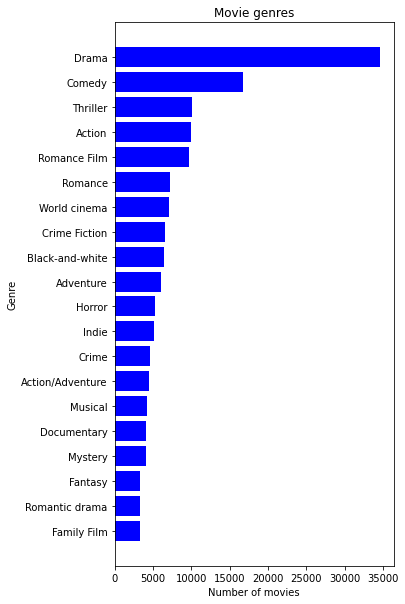

In [28]:
genre_data = MOVIE_DATA["genres"].explode().value_counts()[:20].sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(5,10))
ax.barh(genre_data.index, genre_data.values, color="blue")
ax.set_ylabel("Genre")
ax.set_xlabel("Number of movies")
ax.set_title("Movie genres")
plt.show()

# Analysis of movie production evolution

## Runtime analysis

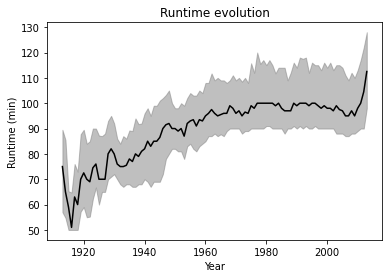

In [29]:
df_runtime = MOVIE_DATA[["movie_release_year", "runtime"]]
des_runtime = df_runtime.groupby("movie_release_year").describe()["runtime"]
des_runtime = des_runtime[des_runtime["count"] >= 5]
plt.fill_between(des_runtime.index, des_runtime["25%"], des_runtime["75%"], alpha = 0.5, color = 'gray')
plt.plot(des_runtime.index, des_runtime["50%"], color = 'black')
plt.xlabel('Year')
plt.ylabel('Runtime (min)')
plt.title('Runtime evolution')
plt.show()

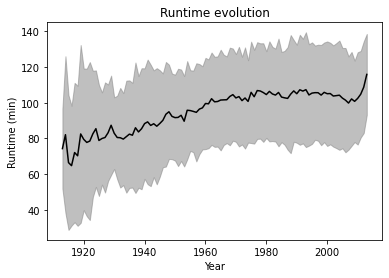

In [30]:
plt.fill_between(des_runtime.index, des_runtime["mean"]-des_runtime["std"], des_runtime["mean"]+des_runtime["std"], alpha = 0.5, color = 'gray')
plt.plot(des_runtime["mean"], color = 'black')
plt.xlabel('Year')
plt.ylabel('Runtime (min)')
plt.title('Runtime evolution')
plt.show()

## Genres analysis

In [103]:
df_genre = []
movie_norm_factor = MOVIE_DATA["movie_release_year"].value_counts()
for year in movie_norm_factor.index:
    row = []
    for genre in genre_data.index:
        matched = MOVIE_DATA[MOVIE_DATA["movie_release_year"] == year]
        matched = matched[matched["genres"].apply(lambda x: genre in x)]
        if len(matched):
            row.append(matched.count()["genres"])
        else:
            row.append(0)
    row = np.asarray(row) / movie_norm_factor[year]
    df_genre.append(row)
df_genre = pd.DataFrame(df_genre, index = movie_norm_factor.index, columns=genre_data.index).sort_index()

<AxesSubplot:>

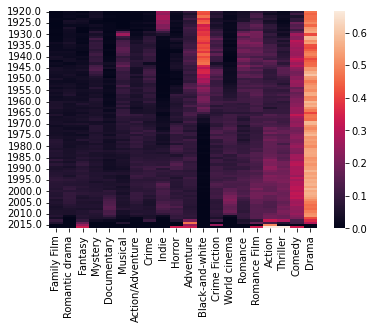

In [104]:
df_genre = df_genre[df_genre.index > 1919]
sns.heatmap(df_genre)

## Main character analysis

In [121]:
df_character = MOVIE_DATA[["movie_release_year", "genres", "main_characters"]].explode("main_characters").dropna()

df_character = df_character.join(CHARACTER_DATA.set_index("freebase_character_actor_map_id")[["actor_gender", "actor_height", "actor_age_at_movie_release"]], on="main_characters")
df_character.head()

,movie_release_year,genres,main_characters,actor_gender,actor_height,actor_age_at_movie_release
975900,2001.0,"{Adventure, Space western, Supernatural, Actio...",/m/0jys3m,F,1.780,27.0
18998739,2002.0,"{Family Film, World cinema, Adventure, Fantasy}",/m/04lrj09,F,1.727,41.0
10408933,1938.0,"{Drama, Musical, Romance, Comedy, Black-and-wh...",/m/02vbvj2,M,1.820,24.0
6631279,1997.0,"{Romantic drama, Drama, Comedy, Ensemble Film,...",/m/04hvbft,F,1.570,37.0
171005,1989.0,"{Drama, Epic, Film adaptation, War, Biography,...",/m/02vdfck,M,1.830,15.0


### Gender fraction

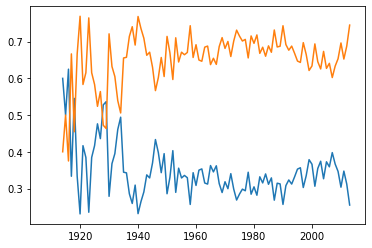

In [126]:
df_character_F = df_character[df_character["actor_gender"] == "F"]["movie_release_year"].value_counts().sort_index()
df_character_M = df_character[df_character["actor_gender"] == "M"]["movie_release_year"].value_counts().sort_index()
df_sum = df_character_F + df_character_M

plt.plot(df_character_F[df_sum > 0] / df_sum)
plt.plot(df_character_M[df_sum > 0] / df_sum)
plt.show()

### Age by gender

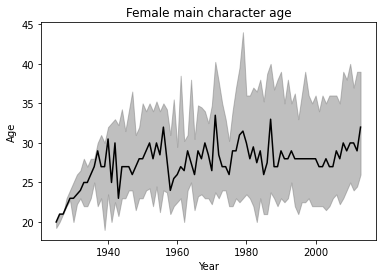

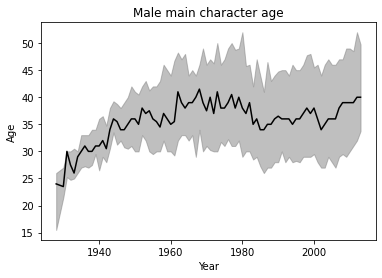

In [128]:
df_character_F = df_character[df_character["actor_gender"] == "F"][["movie_release_year", "actor_age_at_movie_release"]].groupby("movie_release_year").describe()["actor_age_at_movie_release"]
df_character_M = df_character[df_character["actor_gender"] == "M"][["movie_release_year", "actor_age_at_movie_release"]].groupby("movie_release_year").describe()["actor_age_at_movie_release"]
df_character_F = df_character_F[df_character_F["count"] >= 5]
df_character_M = df_character_M[df_character_M["count"] >= 5]

plt.fill_between(df_character_F.index, df_character_F["25%"], df_character_F["75%"], alpha = 0.5, color = 'gray')
plt.plot(df_character_F.index, df_character_F["50%"], color = 'black')
plt.xlabel('Year')
plt.ylabel('Age')
plt.title('Female main character age')
plt.show()

plt.fill_between(df_character_M.index, df_character_M["25%"], df_character_M["75%"], alpha = 0.5, color = 'gray')
plt.plot(df_character_M.index, df_character_M["50%"], color = 'black')
plt.xlabel('Year')
plt.ylabel('Age')
plt.title('Male main character age')
plt.show()

### Height by gender

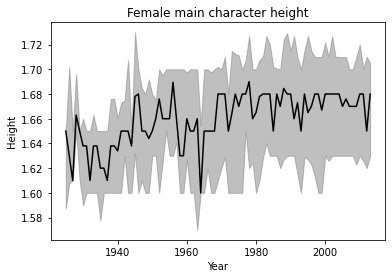

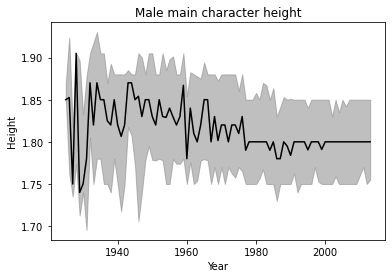

In [129]:
df_character_F = df_character[df_character["actor_gender"] == "F"][["movie_release_year", "actor_height"]].groupby("movie_release_year").describe()["actor_height"]
df_character_M = df_character[df_character["actor_gender"] == "M"][["movie_release_year", "actor_height"]].groupby("movie_release_year").describe()["actor_height"]
df_character_F = df_character_F[df_character_F["count"] >= 5]
df_character_M = df_character_M[df_character_M["count"] >= 5]

plt.fill_between(df_character_F.index, df_character_F["25%"], df_character_F["75%"], alpha = 0.5, color = 'gray')
plt.plot(df_character_F.index, df_character_F["50%"], color = 'black')
plt.xlabel('Year')
plt.ylabel('Height')
plt.title('Female main character height')
plt.show()

plt.fill_between(df_character_M.index, df_character_M["25%"], df_character_M["75%"], alpha = 0.5, color = 'gray')
plt.plot(df_character_M.index, df_character_M["50%"], color = 'black')
plt.xlabel('Year')
plt.ylabel('Height')
plt.title('Male main character height')
plt.show()

### Gender fraction by genre

In [ ]:
#todo

In [33]:
df_box_office = MOVIE_DATA[["movie_release_year", "budget", "budget_inflated", "box_office", "box_office_inflated"]]
des_box_office = df_box_office.groupby("movie_release_year").describe()

In [34]:
# Helper function to format the axes tick labels
def currency(x, pos):
    if x >= 1e9:
        s = '${:1.0f}B'.format(x*1e-9)
    elif x >= 1e6:
        s = '${:1.0f}M'.format(x*1e-6)
    elif x > 0:
        s = '${:1.0f}K'.format(x*1e-3)
    else:
        s = '${:1.0f}'.format(x)
    return s

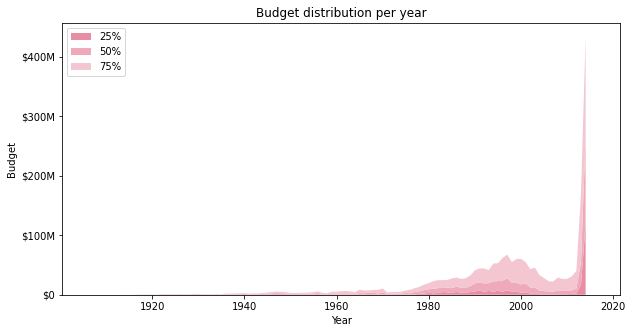

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(des_box_office.index, des_box_office["budget"]["25%"], des_box_office["budget"]["50%"], des_box_office["budget"]["75%"], labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Budget distribution per year")
ax.set_xlabel("Year")
ax.set_ylabel("Budget")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.show()

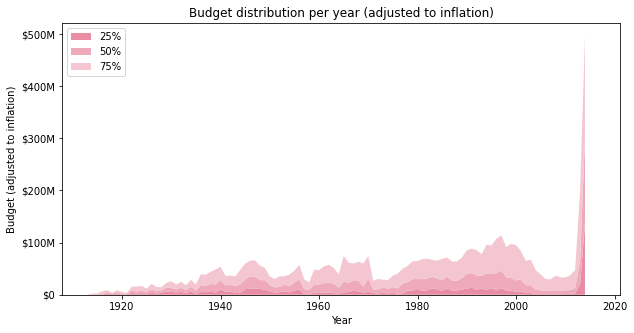

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(des_box_office.index, des_box_office["budget_inflated"]["25%"], des_box_office["budget_inflated"]["50%"], des_box_office["budget_inflated"]["75%"], labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Budget distribution per year (adjusted to inflation)")
ax.set_xlabel("Year")
ax.set_ylabel("Budget (adjusted to inflation)")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.show()

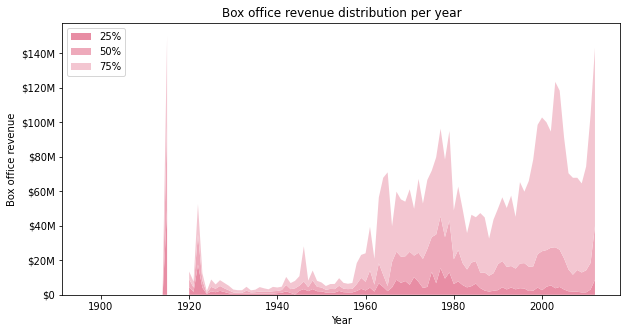

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(des_box_office.index, des_box_office["box_office"]["25%"], des_box_office["box_office"]["50%"], des_box_office["box_office"]["75%"], labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Box office revenue distribution per year")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.show()

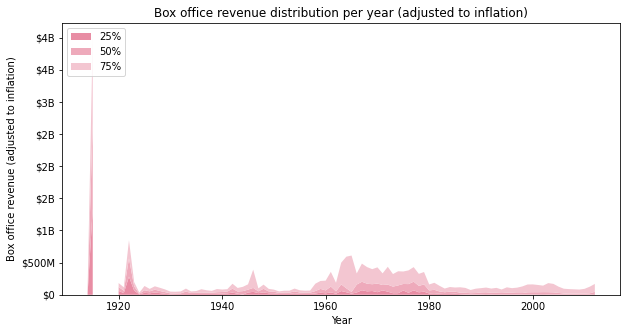

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(des_box_office.index, des_box_office["box_office_inflated"]["25%"], des_box_office["box_office_inflated"]["50%"], des_box_office["box_office_inflated"]["75%"], labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Box office revenue distribution per year (adjusted to inflation)")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue (adjusted to inflation)")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.show()